In [1]:
%matplotlib inline

import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sparse
from scipy.stats import pearsonr

from scipy.cluster.hierarchy import linkage
import scipy.spatial.distance as ssd

import seaborn as sns
import sys
from scipy.sparse import hstack, csr_matrix
from sklearn.feature_selection import mutual_info_classif
import os
from cnmf import cNMF, save_df_to_npz, load_df_from_npz
import harmonypy


from matplotlib.patches import Patch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from matplotlib.patches import Rectangle
from matplotlib.pyplot import rc_context

def save_df_to_text(obj, filename):
    obj.to_csv(filename, sep='\t')


import matplotlib.backends.backend_pdf

sys.path.append('../../Code/')
from utils import read_dataset_log
from matplotlib import rcParams, font_manager
import matplotlib

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# rcParams['pdf.fonttype'] = 42
# rcParams['ps.fonttype'] = 42
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Arial']

In [2]:
tabledir = '../../Tables/'

In [3]:
from scipy.stats import spearmanr

In [4]:
params = read_dataset_log('Dataset Paths')
params.index = params['dataset']
params = params[params['dataset_type']=='discovery']
params

,dataset,usage_fn,gene_scores_fn,gene_tpm_fn,tcat_fn,tcat_fn_withsingletons,manual_gating_fn,manual_activation_gating_fn,activation_score_fn,metadata_fn,...,cnmf_dir,k,dt,processed_forcnmf_fn,tpm_counts_for_cnmf_fn,raw_counts_filt_fn,raw_counts_fn,dataset_type,tissue_type,context_label
dataset,,,,,,,,,,,,,,,,,,,,,
AMP-RA,AMP-RA,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMPRA....,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Manual...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/Activa...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,...,/data/srlab1/TCAT/Data/PerDataset/AMPRA,34.0,0_15,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,/data/srlab1/TCAT/Data/PerDataset/AMPRA/AMP_AD...,discovery,Synovium,RA+OA
Pan-Cancer,Pan-Cancer,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Pa...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/Ac...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,...,/data/srlab1/TCAT/Data/PerDataset/Pancancer,38.0,0.15,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,NaN,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,/data/srlab1/TCAT/Data/PerDataset/Pancancer/pa...,discovery,Pan-Tissue,Cancer+Healthy
TBRU,TBRU,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/PerDataset/TBRU/TBRU.20...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,NaN,/data/srlab1/TCAT/Data/PerDataset/TBRU/ManualG...,/data/srlab1/TCAT/Data/PerDataset/TBRU/Activat...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,...,/data/srlab1/TCAT/Data/PerDataset/TBRU,36.0,0_20,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,/data/srlab1/TCAT/Data/PerDataset/TBRU/tbru_ex...,discovery,Blood,Healthy
HIV-Vaccine,HIV-Vaccine,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/HIVV...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Manu...,NaN,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/Acti...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl,31.0,0_15,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,/data/srlab1/TCAT/Data/PerDataset/HaoEtAl/haoe...,discovery,Blood,Post-Vaccine+Healthy
UK-Covid,UK-Covid,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/UKCO...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Manu...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/Acti...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID,44.0,0_20,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,NaN,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,/data/srlab1/TCAT/Data/PerDataset/UKCOVID/hani...,discovery,Blood,Covid-19+Healthy
COMBAT,COMBAT,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/PerDataset/COMBAT/COMBA...,/data/srlab1/TCAT/Data/TCAT/TCAT_Usage.2023101...,/data/srlab1/TCAT/Data

In [5]:
cgep_info = read_dataset_log('cGEP_Name')
rename_map = dict(zip(cgep_info['cGep_Name'], cgep_info['Short_Name']))

In [6]:
cgep_paths = read_dataset_log('cGEP Paths').loc[0, :]
spectra_scores = pd.read_csv(cgep_paths['scores_spectra'], sep='\t', index_col=0).T.rename(columns=rename_map)
spectra_scores.head()

,CellCycle-G2M,Translation,HLA,ISG,Mito,Doublet-RBC,gdT,CellCycle-S,Cytotoxic,Doublet-Platelet,...,Tfh-2,OX40/EBI3,CD172a/MERTK,IEG3,Doublet-Fibroblast,SOX4/TOX2,CD40LG/TXNIP,Tph,Exhaustion,Tfh-1
SUV39H2,0.000276,-0.000159,0.000002,0.000056,-0.000174,0.000183,0.000022,0.000759,-0.000055,-0.000018,...,0.000020,0.000257,-0.000208,0.000020,-0.000023,0.000054,-0.000155,0.000064,0.000248,-0.000043
GPR68,0.000002,-0.000774,0.000271,-0.000120,0.000136,-0.000157,0.000477,-0.000117,0.000139,0.000084,...,-0.000081,0.000025,-0.000582,-0.000236,-0.000150,-0.000141,-0.000168,0.000737,0.000694,0.000052
LINC02568,0.000009,-0.000049,-0.000015,0.000063,0.000060,-0.000026,-0.000018,0.000016,-0.000008,-0.000073,...,NaN,NaN,-0.000023,-0.000019,NaN,-0.000042,NaN,NaN,NaN,NaN
ZNF567,-0.000026,-0.000546,-0.000337,0.000132,0.000172,0.000047,0.000103,0.000023,-0.000109,-0.000031,...,-0.000020,0.000050,-0.000115,-0.000070,0.000249,0.000326,0.000114,-0.000066,0.000154,0.000026
ERG28,-0.000004,-0.000177,-0.000390,0.000220,-0.001149,0.000026,0.000118,0.000073,0.000400,-0.000142,...,0.000105,0.000451,-0.000037,0.000058,-0.000394,-0.000095,-0.000227,-0.000053,NaN,NaN


In [7]:
import pandas as pd
import openpyxl
from openpyxl.styles import PatternFill
from openpyxl.utils.dataframe import dataframe_to_rows
import numpy as np
import matplotlib.pyplot as plt

def create_colored_excel(text_values, text_colors, filename, vmax=None, vmin=None, tabname='Colored Data'):
    # Normalize the text_colors DataFrame to map to a colormap
    if vmin is None:
        vmin = text_colors.min().min()

    if vmax is None:
        vmax = text_colors.max().max()
    
    norm = plt.Normalize(text_colors.min().min(), text_colors.max().max())
    colors = plt.cm.Blues(norm(text_colors.values))

    def apply_color(wb, sheet_name, df_values, colors):
        ws = wb[sheet_name]
        # Apply values and colors to the cells
        for r_idx, row in enumerate(dataframe_to_rows(df_values, index=False, header=True)):
            for c_idx, value in enumerate(row):
                cell = ws.cell(row=r_idx+1, column=c_idx+1)
                cell.value = value
                if r_idx > 0:  # Skip header row for coloring
                    # Convert RGB to hex
                    rgb = tuple((np.array(colors[r_idx-1][c_idx][:3]) * 255).astype(int))
                    hex_color = f"{rgb[0]:02x}{rgb[1]:02x}{rgb[2]:02x}"
                    cell.fill = PatternFill(start_color=hex_color, end_color=hex_color, fill_type="solid")

    # Create a new workbook and sheet
    wb = openpyxl.Workbook()
    ws = wb.active
    ws.title = tabname

    # Apply color and values to the worksheet
    apply_color(wb, tabname, pd.DataFrame(text_values), colors)

    # Save the workbook
    wb.save(filename)



In [8]:
ntopgenes = 200
text_values = {}
text_colors = {}
for g in spectra_scores.columns:
    dat = spectra_scores[g].sort_values(ascending=False)
    text_values[g] = list(dat.index[:ntopgenes])
    text_colors[g] = list(dat.values[:ntopgenes])

text_values = pd.DataFrame.from_dict(text_values)
text_colors = pd.DataFrame.from_dict(text_colors)

In [9]:
order = cgep_info.loc[cgep_info['Filter']!='F', ['Short_Name', 'Class']].dropna().sort_values(by='Class', ascending=False)
text_values = text_values.loc[:, order['Short_Name']]
text_colors = text_colors.loc[:, order['Short_Name']]

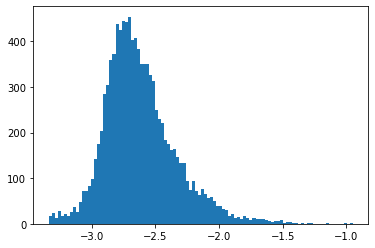

In [10]:
_ = plt.hist(np.log10(text_colors.values.reshape(-1)), bins=100)

In [23]:
filename = os.path.join(tabledir, 'Table_S2_top200genes_percgep_colorcoded.xlsx')
filename

'../../Tables/Table_S2_top200genes_percgep_colorcoded.xlsx'

In [24]:
create_colored_excel(text_values, text_colors, filename, vmax=.003, vmin=0, tabname='cGEP Associated Genes Ranked')

In [13]:
dataset = 'Pan-Cancer'

In [14]:
pd.read_csv(params.loc[dataset, 'gene_scores_fn'], index_col = 0, sep = '\t')

,CD8/KLRC2,CD8_EM,YPEL5/CREM,CD4-Naive,Pan-Cancer:CD4/CD20_Single,Treg,Cytoskeleton,Cytotoxic,IEG-Tissue,RGCC/MYADM,...,CellCycle-S,CellCycle-Histone,High-Cytokine,Pan-Cancer:Metabolic_Single,Pan-Cancer:FXYD6/CAV1_Single,CellCycle-G2M,Pan-Cancer:CellCycle-Histone1_Single,Doublet-Bcell,Metallothionein,Doublet-RBC
ENTPD1-AS1,0.000191,0.000113,-0.000202,0.000066,0.000127,0.000023,-0.000242,0.000064,0.000342,-0.000508,...,0.000088,-0.000004,-0.000160,0.000189,0.000053,0.000069,0.000064,2.602395e-04,-0.000054,0.000155
RNF152,-0.000142,-0.000071,0.000125,-0.000016,-0.000247,-0.000078,-0.000050,-0.000144,-0.000101,-0.000106,...,0.000012,-0.000021,-0.000004,0.002235,0.000003,0.000023,0.000046,1.051513e-04,-0.000056,0.003803
RXRG,-0.000169,-0.000139,-0.000147,0.000064,-0.000343,-0.001464,0.000052,-0.000198,-0.000110,-0.000502,...,-0.000032,0.000016,0.000004,-0.000190,0.000236,0.000072,0.000057,-2.371000e-04,-0.000286,-0.000328
TTC1,0.000180,0.000562,-0.000914,-0.000228,-0.000063,0.000327,0.000195,-0.000128,-0.000815,-0.001133,...,-0.000102,-0.000087,-0.000809,0.000236,-0.000026,-0.000023,-0.000100,2.127193e-04,-0.000216,0.000034
ANXA1,0.000304,-0.001098,-0.002212,-0.001120,0.001081,-0.001853,-0.000772,-0.000302,-0.000579,0.019228,...,0.000052,-0.000322,-0.000541,-0.000025,-0.001076,0.000121,-0.000147,-7.723279e-04,-0.000488,-0.000808
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LIPE-AS1,0.000066,0.000173,-0.000074,-0.000070,-0.000050,0.000033,-0.000037,-0.000023,0.000095,-0.000407,...,-0.000012,-0.000035,-0.000038,0.000557,0.000191,-0.000015,-0.000051,3.153149e-05,0.000279,-0.000175
DDX1,0.000054,0.000252,-0.000517,-0.000082,0.000136,0.000109,-0.000046,0.000060,-0.000249,-0.000621,...,0.000132,-0.000008,-0.000335,0.000531,-0.000174,0.000071,-0.000044,1.043710e-04,-0.000133,0.000544
LINC00907,-0.000017,0.000098,-0.000118,0.000025,0.000007,0.000071,0.000040,0.000019,0.000100,-0.000172,...,-0.000003,-0.000012,0.000056,0.000608,0.000027,-0.000012,-0.000003,-8.212258e-05,0.000021,-0.000138
PLCE1,-0.000118,-0.000024,-0.000128,-0.000057,0.000025,-0.000022,0.000004,-0.000074,-0.000017,-0.000110,...,0.000030,-0.000018,0.000024,0.001247,0.000059,0.000028,-0.000081,-2.395936e-07,-0.000025,-0.000089


In [15]:
cgep_params = read_dataset_log('cGEP Paths').iloc[0,:]
cgep_params

clustering_fn                                /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
clustering_with_singletons_fn                /data/srlab1/TCAT/Data/TCAT/cluster_groups.pai...
merged_hvgs                                  /data/srlab1/TCAT/Data/TCAT/MergedHVG_UnionAll...
tpm_varnorm_spectra                          /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_varnorm_spectra_withsingletons           /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_renorm_varnorm_spectra                   /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
tpm_renorm_varnorm_spectra_withsingletons    /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra                               /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
scores_spectra_withsingletons                /data/srlab1/TCAT/Data/TCAT/merged_spectra.Gen...
correlation_matrix_tpm_renorm_varnorm        /data/srlab1/TCAT/Data/TCAT/R.TPMrenorm.VarNor...
correlation_matrix_spectra                   /data

In [16]:
gene_scores = pd.read_csv(cgep_params['scores_spectra'], index_col = 0, sep = '\t')
gene_scores.index = gene_scores.index.map(rename_map)

In [17]:
gep = 'Tfh-1'

In [18]:
gene_scores.loc[gep, :].sort_values(ascending = False).dropna().head(50)

TOX2        0.015068
SMCO4       0.010750
KSR2        0.010490
PEG10       0.009795
CXCR5       0.009355
ANKRD34B    0.009281
PVALB       0.009107
PARD3       0.008647
IL6ST       0.008592
NTRK3       0.008573
SLC7A10     0.008543
LIMS2       0.008471
POU2AF1     0.008166
FZD3        0.008006
EDN3        0.007965
TSPAN12     0.007961
SCGB3A1     0.007791
CHI3L2      0.007733
MAP7        0.007531
GNG4        0.007435
ICA1        0.007417
SESN1       0.007258
CD79A       0.006964
PTPN14      0.006190
ITM2A       0.005672
FBLN7       0.005637
CPA5        0.005621
SMAD1       0.005609
PRKAR2B     0.005605
IL6R        0.005453
CHGB        0.005435
LIMS1       0.005365
FILIP1L     0.005289
CLDN1       0.005257
CA8         0.005180
HAL         0.005131
TOX         0.005059
TCF7        0.004923
PPP1CC      0.004833
PTPN13      0.004829
MME         0.004775
SMPDL3A     0.004763
CAV1        0.004707
ASCL2       0.004477
ANKRD55     0.004410
ADD3        0.004339
PDCD1       0.004278
FAM107B     0

In [19]:
gene_scores.loc[gep, :].sort_values(ascending = False).dropna().head(100).tail(50)

CD200         0.004047
NUDT16        0.004027
KIAA1324      0.004010
AFF3          0.004007
HEYL          0.003998
CDK14         0.003985
CORO1B        0.003940
C1orf228      0.003855
FKBP5         0.003775
ACTN1         0.003764
MCTP1         0.003726
CXCL13        0.003627
SERTAD4       0.003494
THADA         0.003484
SLC9A9        0.003468
SERPINE2      0.003432
SGCE          0.003422
PASK          0.003416
TIGIT         0.003414
HIF1A         0.003387
FAM134B       0.003367
IGFBP4        0.003363
PTPN11        0.003350
CKAP4         0.003348
TIAM1         0.003293
SYT17         0.003283
SEPT6         0.003282
LRRC8D        0.003247
CDH2          0.003246
C9orf16       0.003173
NCALD         0.003139
ADTRP         0.003113
SH2D1A        0.003102
APBB2         0.003093
TPD52L1       0.003080
XXYLT1-AS2    0.003080
SMAP2         0.003078
FAAH2         0.003077
ROR1          0.003021
NFATC1        0.003021
YPEL3         0.002983
FLT1          0.002968
ZFAT          0.002939
ACSBG1     

In [20]:
gep = 'Tfh-2'

In [21]:
gene_scores.loc[gep, :].sort_values(ascending = False).dropna().head(50)

LHFP         0.009026
CD200        0.008728
LINC01991    0.007884
GNG4         0.006778
LHFPL6       0.006135
LINC01480    0.006132
NMB          0.006004
CXCL13       0.005441
ICA1         0.005392
IGFL2        0.005317
SERPINE2     0.005210
CPM          0.004967
KSR2         0.004240
DOK5         0.004064
BTLA         0.004021
MAP7         0.003991
NEBL         0.003840
LINC01281    0.003813
MS4A6A       0.003811
PGM2L1       0.003674
POU2AF1      0.003634
RDH10        0.003595
DRAIC        0.003574
ARMH1        0.003467
TUBA3D       0.003427
TSPAN12      0.003410
RGS4         0.003408
PHEX         0.003355
FABP5        0.003294
ENOX1        0.003280
IGFBP4       0.003244
ITM2A        0.003242
SLCO5A1      0.003238
FAIM2        0.003148
KCNJ2        0.003097
PTHLH        0.003083
LINC02389    0.003077
DFNA5        0.003051
C1orf228     0.003031
CNKSR3       0.003023
CHGB         0.002928
AHI1         0.002925
FBLN7        0.002878
IL21         0.002837
KIAA1324     0.002800
TNFSF11   

In [22]:
gene_scores.loc[gep, :].sort_values(ascending = False).dropna().head(100).tail(50)

PDCD1         0.002691
ZBED2         0.002601
TPD52L1       0.002599
TOX           0.002575
AZIN1-AS1     0.002569
MAGEH1        0.002549
NTRK3         0.002543
PPP1CC        0.002524
FZD3          0.002443
TOX2          0.002418
NFATC1        0.002396
PTF1A         0.002393
CDK14         0.002326
CNIH1         0.002313
AB_CD279      0.002304
PDE7B         0.002271
TSHZ2         0.002268
SMCO4         0.002224
KCNJ6         0.002205
LINC02341     0.002204
MYH6          0.002169
CPA5          0.002125
TIGIT         0.002106
MEST          0.002089
SOD1          0.002051
CTHRC1        0.002046
BMERB1        0.002045
CAV1          0.002031
SLC28A3       0.002024
KIAA1217      0.002021
HSD11B1       0.002019
MRC1          0.002019
CTTN          0.002002
BCAT1         0.001971
GSDME         0.001962
DAZL          0.001949
XXYLT1-AS2    0.001928
C9orf16       0.001883
LBH           0.001882
CA8           0.001876
SLC30A3       0.001857
GEM           0.001849
H2AFZ         0.001829
CCDC50     